In [1]:
import os
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import random
import time
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from IPython.display import clear_output
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
from numpy import save
from IPython.display import clear_output
from tqdm import tqdm

Now since we have imported out required liberaries 
We will be creating a dataframe to save the image paths with image labels
So, that the images could be fetched in batches when needed without using a lot memory 

We can now directly load our trained model from saved .h5 file

In [2]:
model = keras.models.load_model('saver/trained_model.h5')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        7

In order to get similar images we have to generate a vector corresponding to the images
and finding the closest vector to our query image to get the vectors of similar images
Here I am using the cosine distance but you can use hamming distance also

We are defining our feature extractors upto dense layers 
Here I have used dense layers named f1 and f2 for generating vectors or features for an image

<img src="Images/conv_model_vectors.png" width=800 /> ![](Images/conv_model_vectors.png)

In [4]:

feat_extractor_256 = Model(inputs=model.input,outputs=model.get_layer("f1").output)
feat_extractor_1024 = Model(inputs=model.input,outputs=model.get_layer("f2").output)

feat_extractor_256.summary()
feat_extractor_1024.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512   

function load_image will return images and array format of image

In [5]:

import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
  img = image.load_img(path,target_size=model.input_shape[1:3])
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)
  return img,x

We can limit our program to analyze a limited amount of images 
and getting the image paths upto the limit

In [6]:
df = pd.read_csv('train.csv')

In [7]:
images = df['img_name'].to_list()

Now we are generating feature vectors for the images by using feature extractor models

In [9]:


features = []
for i, image_path in enumerate(tqdm(images)):
#   if i%500 == 0:
#     toc = time.time()
#     elap = toc-tic;
#     print("analyzing image %d / %d. Time taken : %4.4f seconds"%(i,len(images),elap))
#     tic= time.time()
#     clear_output(wait=True)
  img,x = load_image(image_path)
  feat1 = feat_extractor_256.predict(x)[0]
  feat2 = feat_extractor_1024.predict(x)[0]
  feat1 = feat1.reshape(-1,1)
  feat2 = feat2.reshape(-1,1)
  feat = np.vstack((feat1,feat2))
  features.append(feat)
print('finished extracting features for %d images' % len(images))

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [46:23<00:00, 17.97it/s]

finished extracting features for 50000 images


saving feature vectors for furthur use as a backup

In [10]:
#save('features.npy', features) 

In [11]:
# features = np.load('features.npy')

In [12]:
features = np.array(features)

In [13]:
features = features.reshape(-1, 1280,)

# Curse of Dimensionality



<img src="Images/1_V9yJUH9tVrMQI88TuIkCFQ.gif" width=800 /> ![](Images/1_V9yJUH9tVrMQI88TuIkCFQ.gif)

In [14]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=1024)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
pca_features = pca.transform(features)

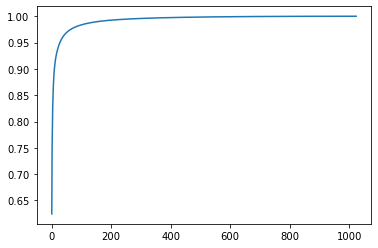

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))




<img src="Images/cosine-similarity-1007790.jpg" width=800 /> ![](Images/cosine-similarity-1007790.jpg)

In [17]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=20):     #num_results is the number of top similar images for query
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

In [18]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'Result images')

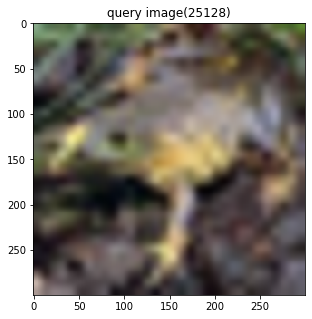

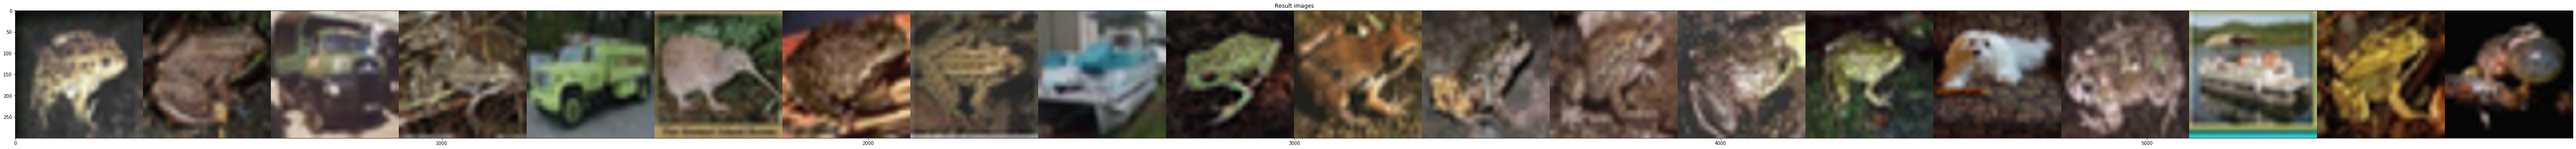

In [22]:
import random
query_image_idx = int(len(images)*random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx],300)
results_image = get_concatenated_images(idx_closest,300)

plt.figure(figsize=(5,5))
plt.imshow(query_image)
plt.title("query image(%d)" %query_image_idx)

plt.figure(figsize=(100,220))
plt.imshow(results_image)
plt.title("Result images")